In [1]:
import tensorflow
print(tensorflow.__version__)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.layers import TimeDistributed,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed, Masking, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# tf.config.set_visible_devices([], 'GPU')
# 禁用GPU 这样才能成功的分配内存


for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


import os
import re
import gc


2024-04-08 01:31:39.432374: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.9.0


In [2]:
class MemoryDataGenerator(Sequence):
    def __init__(self, X_data, Y_data, batch_size):
        self.X_data = X_data
        self.Y_data = Y_data
        self.batch_size = batch_size
    
    def __len__(self):
        # 计算在给定数据集大小下的批次数量
        return int(np.ceil(len(self.X_data) / self.batch_size))
    
    def __getitem__(self, index):
        # 生成批次的数据索引
        batch_start = index * self.batch_size
        batch_end = (index + 1) * self.batch_size
        
        # 根据索引获取当前批次的数据
        batch_X = self.X_data[batch_start:batch_end]
        batch_Y = self.Y_data[batch_start:batch_end]
        
        # 对当前批次的数据进行填充
        # 现在感觉并不需要
        # batch_X_padded = tensorflow.keras.preprocessing.sequence.pad_sequences(batch_X, padding="post", value=special_value, dtype='float32')
        
        # batch_Y_padded = tensorflow.keras.preprocessing.sequence.pad_sequences(batch_Y, padding="post", value=special_value, dtype='float32')
        
        return np.array(batch_X), np.array(batch_Y)
        # 目的: 确保数据以适合模型处理的格式（如float32）被送入训练过程。
        # 操作: 将填充后的数据转换为NumPy数组，并确保数据类型为float32，这是大多数深度学习框架进行计算的首选格式。
    

def loading_data(folder):

    # use regular expression to filter files
    # file's name start with 'ML'
    check_name = re.compile('^ML')

    datasets = []

    # due to different operating system has different way in keeping files, here I would like to read files in sorted by name order and say it explicitly
    # the reason why must sorted by name will be explained later
    for filename in sorted(os.listdir(folder)):

        files = os.path.join(folder, filename)

        # check whether the name match the regular expression and actually is a file
        # 对文件名进行顺序排序，这对于数据保持时间顺序至关重要
        if re.match(check_name, filename) and os.path.isfile(files):

            # using pandas to read csv file
            # there are only three headers: Speed, Steering_angle, LiDAR_scan. 
            # But there are 1083 columns data, which means the number of header doesn't match number of column
            # So, we need to skip first row, and set header is None.
            # Besides, the value in last column is all None, we have to drop column at index -1
            temp = pd.read_csv(files, skiprows=1, header=None).iloc[:, :-1]

            # Because the speed is a very large number compare to steering angle,
            # We have to normalize it into [-1, 1], and do the same to steering angle
            # When apply the model in the simulator, remember to product corresponding value to the output of the model
            # index 0 is speed, index 1 is steering angle
            temp[0] = temp[0].map(lambda t : t/16.0)
            temp[1] = temp[1].map(lambda t : t/0.192)

            # append this csv file to the result, and turn it into numpy array with float format
            datasets.append(np.array(temp, dtype=float))

    # when append data to a list, there will be a copy of old list, which took a lot of memory
    # but there is no reference to them, so we can call the garbage collector
    gc.collect()

    # datasets is a 3D list, shape 0 is number of csv files, shape 1 is number of rows in that csv file, shape 2 is 1083
    return datasets

def loading_speed_steering_data(folder):

    # file's name start with 'car_state_blue'
    check_name = re.compile('^car_state_blue')

    datasets = []

    # Also need to iterate in sorted by name order
    for filename in sorted(os.listdir(folder)):

        files = os.path.join(folder, filename)

        if re.match(check_name, filename) and os.path.isfile(files):

            # We need another two columns from car_state_blue files,
            # one is Velocity_X, another is Steering_angle
            datasets.append(np.array(pd.read_csv(files).iloc[:, [3, 5]], dtype=float))

    gc.collect()
    # datasets is a 3D list, shape 0 is number of csv files, shape 1 is number of rows in that csv file, shape 2 is 2
    return datasets

In [3]:
def load_data_from_folders(folders):
    all_datasets = []  # 这里假设所有数据集的数据将被合并到一个单一的列表中
    all_speed_steering = []  # 同上，对于速度和转向数据
    
    for folder in folders:
        # 加载当前文件夹的数据
        datasets = loading_data(folder)
        speed_steering = loading_speed_steering_data(folder)
        
        # 假设datasets和speed_steering是列表形式的数据，我们可以扩展现有列表以包含新加载的数据
        all_datasets.extend(datasets)  # 扩展而不是附加以保持列表元素的平坦
        all_speed_steering.extend(speed_steering)
    
    return all_datasets, all_speed_steering

# 使用示例
# folders = ["/root/autodl-tmp/Dataset_shanghai", "/root/autodl-tmp/Australia_dataset", "/root/autodl-tmp/Gulf_dataset", "/root/autodl-tmp/Malaysian_dataset"]
folders = ["/root/autodl-tmp/Dataset_shanghai"]
datasets, speed_steering = load_data_from_folders(folders)
# folders2 = ["/root/autodl-tmp/Dataset_shanghai"]
# datasets_test, speed_steering_test = load_data_from_folders(folders2)

In [4]:
new_datasets = datasets
new_speed_steering = speed_steering

special_value = -100
feature_size = 1083


X = []
Y = []

for data, speed_steering in zip(new_datasets, new_speed_steering):
    # 将LiDAR数据（除了前两列外的所有列）和速度、转向角数据（从new_speed_steering）合并
    current_features = np.concatenate((data[:, 2:], speed_steering), axis=1)
    X.append(current_features)

    # 使用前两列作为要预测的目标
    Y.append(data[:, 0:2])


# 遍历X并输出每个序列的长度
# for i, seq in enumerate(X):
#     print(f"序列 {i+1} 的长度: {len(seq)}")


# 对较短的序列进行填充
# Xpad = tensorflow.keras.preprocessing.sequence.pad_sequences(X, padding='post', value=special_value)
# Ypad = tensorflow.keras.preprocessing.sequence.pad_sequences(Y, padding='post', value=special_value)

# # 截断长度大于4000的序列
# X_trimmed = [x if len(x) <= 4000 else x[:4000] for x in X]
# Y_trimmed = [y if len(y) <= 4000 else y[:4000] for y in Y]


# 从截断序列更换成抛弃过长序列，否则单纯截断会造成数据不好
# Define a new function to filter out sequences longer than 4000 timesteps
def filter_sequences(sequences, max_length=4000):
    # Keep only sequences with length less than or equal to max_length
    filtered = [seq for seq in sequences if len(seq) <= max_length]
    return filtered

# Apply filtering to both X (features) and Y (labels) datasets
X_filtered = filter_sequences(X)
Y_filtered = filter_sequences(Y)

# Note: It's important that the filtering is done in a way that retains the correspondence
# between X and Y. The above code assumes that both X and Y are lists of sequences
# and that the ith element of X corresponds to the ith element of Y.


# # 填充至最大长度
# Xpad = tensorflow.keras.preprocessing.sequence.pad_sequences(X_trimmed, padding='post', value=special_value)
# Ypad = tensorflow.keras.preprocessing.sequence.pad_sequences(Y_trimmed, padding='post', value=special_value)

Xpad = tensorflow.keras.preprocessing.sequence.pad_sequences(X_filtered, padding='post', value=special_value)
Ypad = tensorflow.keras.preprocessing.sequence.pad_sequences(Y_filtered, padding='post', value=special_value)




print(len(Xpad))
print("Xpad shape:", Xpad.shape)
print("Ypad shape:", Ypad.shape)

# Xpad shape: (193, 6847, 1083)
# Ypad shape: (193, 6847, 2)
# 193样本数量，193个超车实例；  6847超车实例中所用时间最多的时间步长   ；1083每个时间步长中的元素值


178
Xpad shape: (178, 3997, 1083)
Ypad shape: (178, 3997, 2)


In [5]:
train_generator = MemoryDataGenerator(Xpad, Ypad, batch_size=4)

# 假设input_shape是根据您的数据调整过的，例如，(None, 1081) 其中None代表可变的时间步长
input_shape = (None, feature_size)  # feature_size根据您的特征数量调整


# 定义模型输入
inputs = Input(shape=input_shape)

# 掩码层
masked = Masking(mask_value=special_value)(inputs)

# GRU层
# gru1 = GRU(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(masked)
# gru2 = GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(gru1)

gru1 = GRU(256, return_sequences=True, dropout=0.2)(masked)
gru2 = GRU(128, return_sequences=True, dropout=0.2)(gru1)

# 时间分布密集层
outputs = TimeDistributed(Dense(2, activation='linear', kernel_regularizer=l2(0.01)))(gru2)

# 创建模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])

# 模型总结
model.summary()

# 假设train_generator, Xpad, Ypad已经准备好
# 训练模型
history = model.fit(
    train_generator,
    epochs=10,  # 举例，根据需要调整
    validation_data=train_generator
)

# 评估模型
test_loss, test_mae = model.evaluate(Xpad, Ypad)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")




2024-04-08 01:32:33.750657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 01:32:34.667278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22302 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:43:00.0, compute capability: 8.6
2024-04-08 01:32:34.668210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22302 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:44:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1083)]      0         
                                                                 
 masking (Masking)           (None, None, 1083)        0         
                                                                 
 gru (GRU)                   (None, None, 256)         1029888   
                                                                 
 gru_1 (GRU)                 (None, None, 128)         148224    
                                                                 
 time_distributed (TimeDistr  (None, None, 2)          258       
 ibuted)                                                         
                                                                 
Total params: 1,178,370
Trainable params: 1,178,370
Non-trainable params: 0
___________________________________________________

2024-04-08 01:32:39.244214: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


45/45 [==============================] - 700s 15s/step - loss: 0.2247 - mae: 0.4040 - val_loss: 0.0707 - val_mae: 0.1761
Epoch 2/10
45/45 [==============================] - 691s 15s/step - loss: 0.0638 - mae: 0.1449 - val_loss: 0.0599 - val_mae: 0.1237
Epoch 3/10
45/45 [==============================] - 694s 15s/step - loss: 0.0589 - mae: 0.1253 - val_loss: 0.0584 - val_mae: 0.1284
Epoch 4/10
45/45 [==============================] - 691s 15s/step - loss: 0.0557 - mae: 0.1061 - val_loss: 0.0551 - val_mae: 0.1049
Epoch 5/10
45/45 [==============================] - 695s 15s/step - loss: 0.0540 - mae: 0.1046 - val_loss: 0.0540 - val_mae: 0.1162
Epoch 6/10
45/45 [==============================] - 692s 15s/step - loss: 0.0526 - mae: 0.1057 - val_loss: 0.0515 - val_mae: 0.1033
Epoch 7/10
45/45 [==============================] - 690s 15s/step - loss: 0.0516 - mae: 0.1081 - val_loss: 0.0491 - val_mae: 0.0945
Epoch 8/10
45/45 [==============================] - 695s 15s/step - loss: 0.0497 - mae:

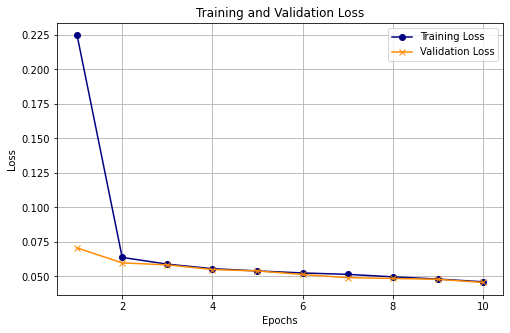

In [6]:
import matplotlib.pyplot as plt
import os

# 假定 history 对象中包含了训练和验证的损失以及MAE
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(train_loss) + 1)

# 绘制损失曲线并保存
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'navy', label='Training Loss', marker='o')
plt.plot(epochs, val_loss, 'darkorange', label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # 添加网格线

# 定义损失图像保存路径
save_path_loss = '/root/autodl-tmp/models/计算时间和资源实验/1.GRU_改了截断_加ecurrent_drop/GRU_model1_loss.png'
# 检查目录是否存在，如果不存在，则创建
if not os.path.exists(os.path.dirname(save_path_loss)):
    os.makedirs(os.path.dirname(save_path_loss))
# 保存图形到文件，设置保存时的背景色
plt.savefig(save_path_loss, dpi=300, bbox_inches='tight', facecolor='white')

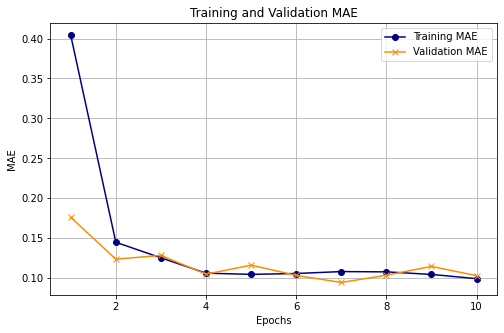

In [7]:
# 绘制MAE曲线并保存
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_mae, 'navy', label='Training MAE', marker='o')
plt.plot(epochs, val_mae, 'darkorange', label='Validation MAE', marker='x')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)  # 添加网格线

# 定义MAE图像保存路径
save_path_mae = '/root/autodl-tmp/models/计算时间和资源实验/1.GRU_改了截断_加ecurrent_drop/GRU_model1_mae.png'
# 检查目录是否存在，如果不存在，则创建
if not os.path.exists(os.path.dirname(save_path_mae)):
    os.makedirs(os.path.dirname(save_path_mae))
# 保存图形到文件，设置保存时的背景色
plt.savefig(save_path_mae, dpi=300, bbox_inches='tight', facecolor='white')


In [8]:
model.save("/root/autodl-tmp/models/计算时间和资源实验/1.GRU_改了截断_加ecurrent_drop/")

INFO:tensorflow:Assets written to: /root/autodl-tmp/models/计算时间和资源实验/1.GRU_改了截断_加ecurrent_drop/assets
